<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/GET_FII_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance


     |████████████████████████████████| 6.3 MB 10.1 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=f6c174f3cf4f8037bef55e4c6c4be84ef60f3c4884c6a5b3eccff6d6d54521f7
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import plotly.express as px
import plotly.graph_objects as go


In [3]:

import numpy as np
import pandas as pd
import yfinance as yf


In [4]:
nifty=yf.download('^NSEI',start='2018-08-08')
nif=nifty.reset_index()

[*********************100%***********************]  1 of 1 completed


In [5]:
import matplotlib.pyplot as plt

In [6]:
content='https://raw.githubusercontent.com/anirbanghoshsbi/data/main/'

In [7]:
data1=pd.read_csv(content+'fii1.txt',sep='\t',header=None)
data2=pd.read_csv(content+'fii2.txt',sep='\t',header=None)
data3=pd.read_csv(content+'fii3.txt',sep='\t',header=None)
data4=pd.read_csv(content+'fii4.txt',sep='\t',header=None)
data5=pd.read_csv(content+'fii5.txt',sep='\t',header=None)
data6=pd.read_csv(content+'fii6.txt',sep='\t',header=None)
data7=pd.read_csv(content+'fii7.txt',sep='\t',header=None)
data8=pd.read_csv(content+'fii8.txt',sep='\t',header=None)


In [8]:
data=[]

In [9]:
data=data1[0].tolist()
data.extend(data2[0].tolist())
data.extend(data3[0].tolist())
data.extend(data4[0].tolist())
data.extend(data5[0].tolist())
data.extend(data6[0].tolist())
data.extend(data7[0].tolist())
data.extend(data8[0].tolist())

In [10]:
len(data)

5187

In [11]:
lst=[]
lst.append(data[0:7])

In [12]:
for i in range(7,len(data)):
  if i%7==0:
    #print(i)
    lst.append(data[i:i+7])




In [13]:
df=pd.DataFrame()

In [14]:
for item in lst:
  to_append=item
  a_series = pd.Series(to_append)
  df = df.append(a_series, ignore_index=True)
print(df)

               0      1      2      3       4      5     6
0    17 Aug 2021    5.5   50.5  -459   15932    -344  266 
1    16 Aug 2021   11.7   -2.6   -332   16115  -1088   506
2    13 Aug 2021   60.0   37.2    631   15936    820   150
3    12 Aug 2021   31.4   -6.2   +889   14678   -212   308
4    11 Aug 2021    1.3   11.6   -905   14977    238   206
..           ...    ...    ...    ...     ...    ...   ...
736  20 Aug 2018   1.9   -5.6   -118   31185   -483   593 
737  17 Aug 2018  15.6    4.0   -695   30356    147   152 
738  16 Aug 2018  -8.9   11.6   -433   28720   -825   134 
739  14 Aug 2018   3.4    7.7   -711   28727   -379   391 
740  13 Aug 2018  -2.9    1.0   -722   28024   -972   216 

[741 rows x 7 columns]


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741 entries, 0 to 740
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       741 non-null    object
 1   1       741 non-null    object
 2   2       741 non-null    object
 3   3       741 non-null    object
 4   4       741 non-null    object
 5   5       741 non-null    object
 6   6       741 non-null    object
dtypes: object(7)
memory usage: 40.6+ KB


In [16]:
df.to_csv('fii.csv')

In [17]:
fii_fig= pd.read_csv('/content/fii.csv')

In [18]:
fii_fig=fii_fig[::-1]

In [19]:
fii_fig.tail(2)

,Unnamed: 0,0,1,2,3,4,5,6
1,1,16 Aug 2021,11.7,-2.6,-332,16115,-1088,506
0,0,17 Aug 2021,5.5,50.5,-459,15932,-344,266


In [20]:
fii_fig.columns =['Index','Date','FIIcall','FIIput','FIIFuture','FIIFutOI','FIICash','DIIcash']

In [21]:
fii_fig.drop('Index',inplace=True,axis=1)

In [22]:
fii_fig=fii_fig.set_index('Date')

In [23]:
fii_fig.tail(3)

,FIIcall,FIIput,FIIFuture,FIIFutOI,FIICash,DIIcash
Date,,,,,,
13 Aug 2021,60.0,37.2,631,15936,820,150
16 Aug 2021,11.7,-2.6,-332,16115,-1088,506
17 Aug 2021,5.5,50.5,-459,15932,-344,266


In [24]:
fii_fig['Cash']=fii_fig.FIICash-fii_fig.DIIcash

In [25]:
fii_fig['macdfut']=fii_fig['FIIFuture'].ewm(span=150, adjust=False).mean()-fii_fig['FIIFuture'].ewm(span=300, adjust=False).mean()
fii_fig['signalfut']=fii_fig['macdfut'].ewm(span=95,adjust=False).mean()
fii_fig['signal10fut']=fii_fig['macdfut'].ewm(span=20,adjust=False).mean()
fii_fig['histfut']=fii_fig['macdfut']-fii_fig['signalfut']

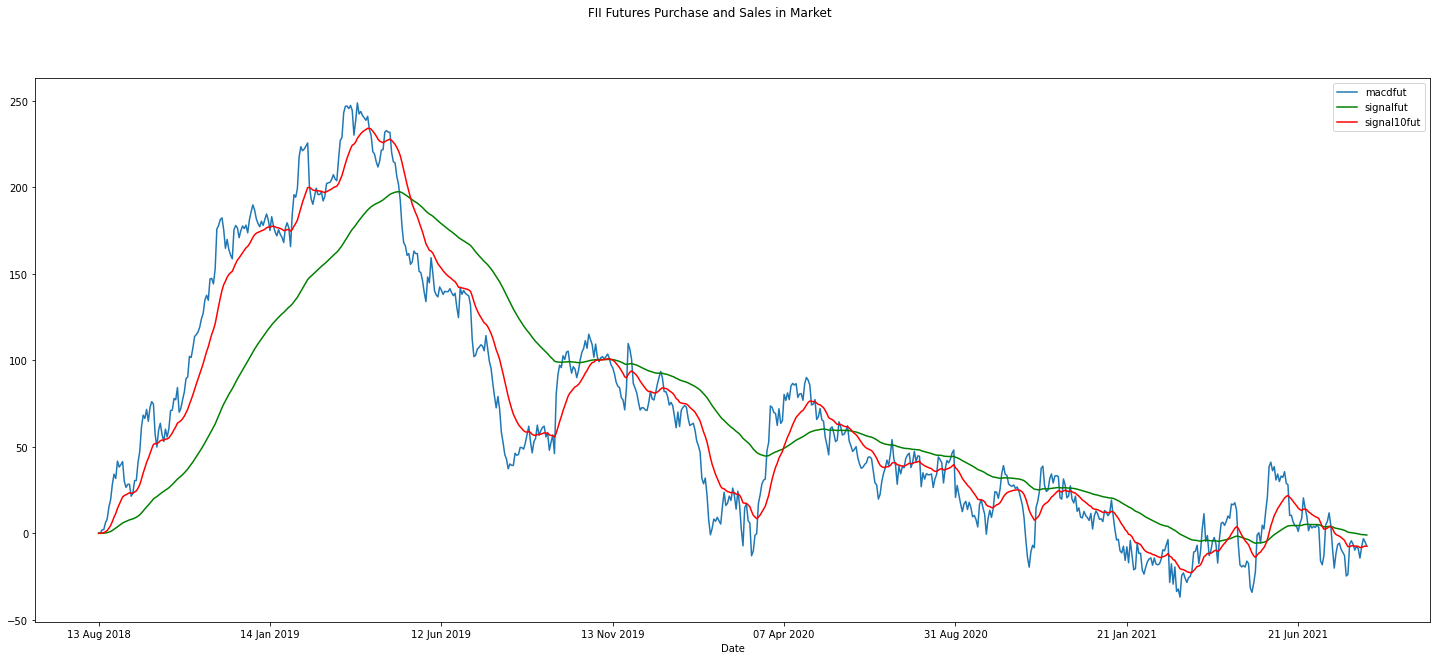

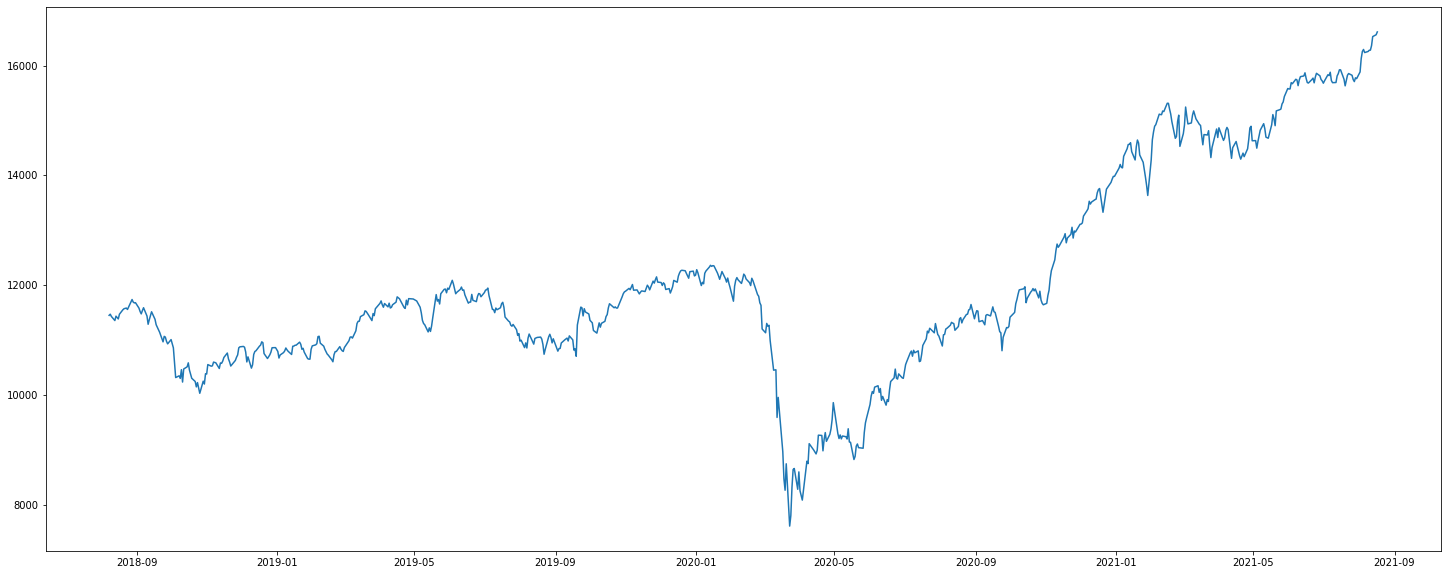

In [26]:
fii_fig['macdfut'].plot(figsize=(25,10))
fii_fig['signalfut'].plot(color='g')
fii_fig['signal10fut'].plot(color='r')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII Futures Purchase and Sales in Market')
plt.legend()
plt.show()
plt.figure(figsize=(25,10))
plt.plot(nifty.Close)
plt.show()

# Plot FII minus DII

In [27]:
fii_fig['macdy']=fii_fig['Cash'].ewm(span=50, adjust=False).mean()-fii_fig['Cash'].ewm(span=200, adjust=False).mean()
fii_fig['signaly']=fii_fig['macdy'].ewm(span=35,adjust=False).mean()
fii_fig['signal10y']=fii_fig['macdy'].ewm(span=10,adjust=False).mean()
fii_fig['histy']=fii_fig['macdy']-fii_fig['signaly']

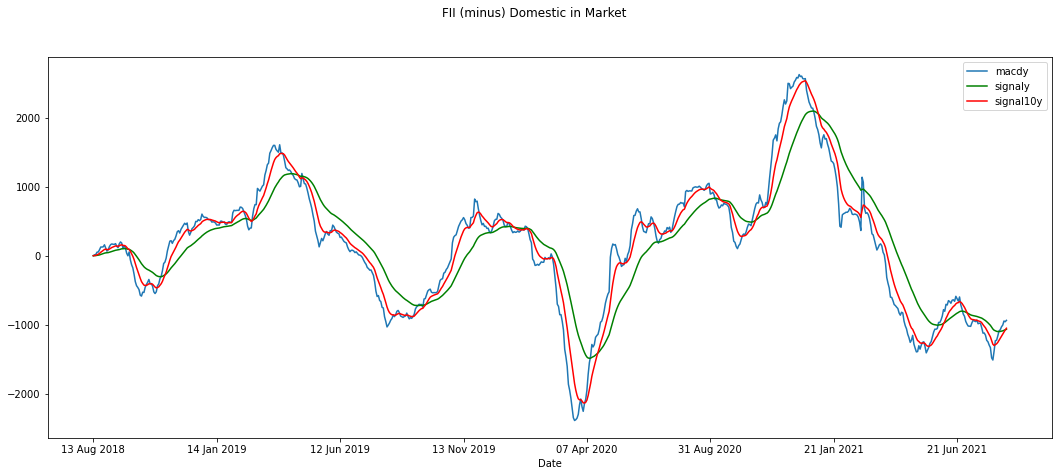

In [28]:
fii_fig['macdy'].plot(figsize=(18,7))
fii_fig['signaly'].plot(color='g')
fii_fig['signal10y'].plot(color='r')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII (minus) Domestic in Market')
plt.legend()
plt.show()

In [29]:
fii_fig['macd']=fii_fig['DIIcash'].ewm(span=50, adjust=False).mean()-fii_fig['DIIcash'].ewm(span=200, adjust=False).mean()
fii_fig['signal']=fii_fig['macd'].ewm(span=35,adjust=False).mean()
fii_fig['signal10']=fii_fig['macd'].ewm(span=10,adjust=False).mean()
fii_fig['hist']=fii_fig['macd']-fii_fig['signal']

In [30]:
fii_fig['macdx']=fii_fig['FIICash'].ewm(span=50, adjust=False).mean()-fii_fig['FIICash'].ewm(span=200, adjust=False).mean()
fii_fig['signalx']=fii_fig['macdx'].ewm(span=35,adjust=False).mean()
fii_fig['signal10x']=fii_fig['macdx'].ewm(span=10,adjust=False).mean()
fii_fig['histx']=fii_fig['macdx']-fii_fig['signalx']

# Plot FII , DII , Difference comparison

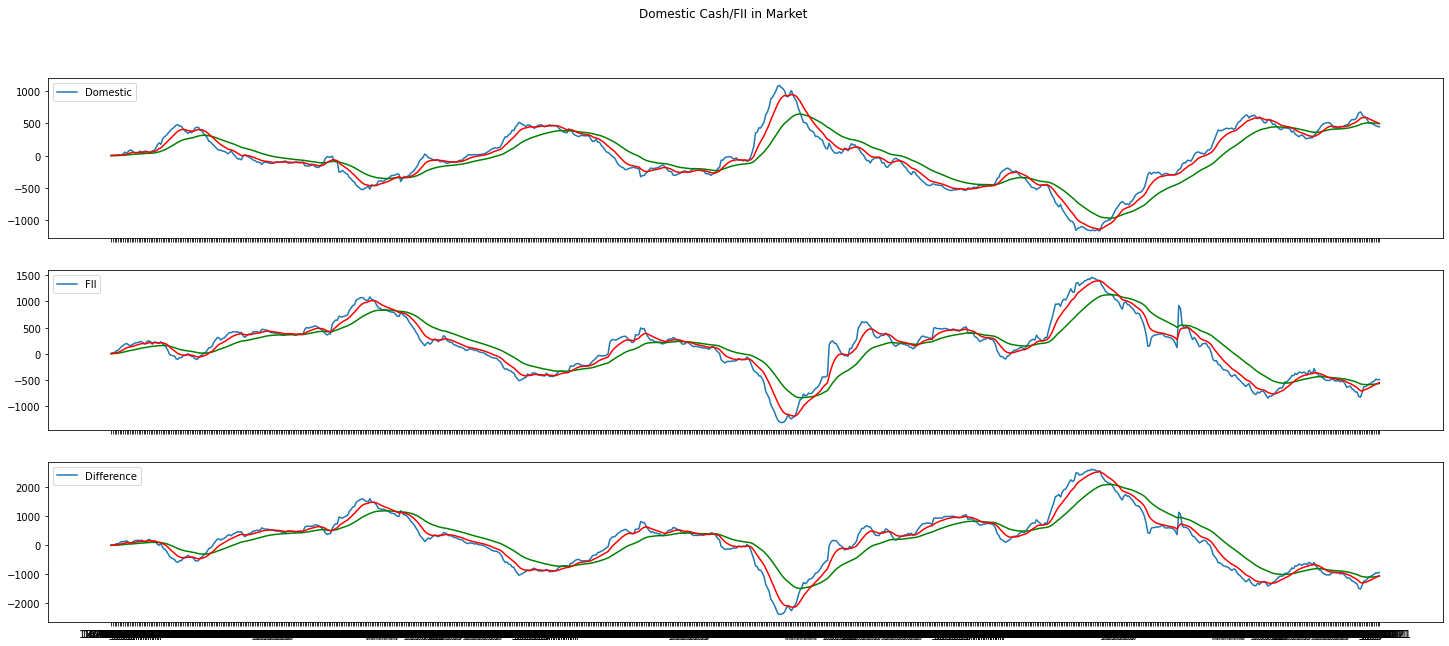

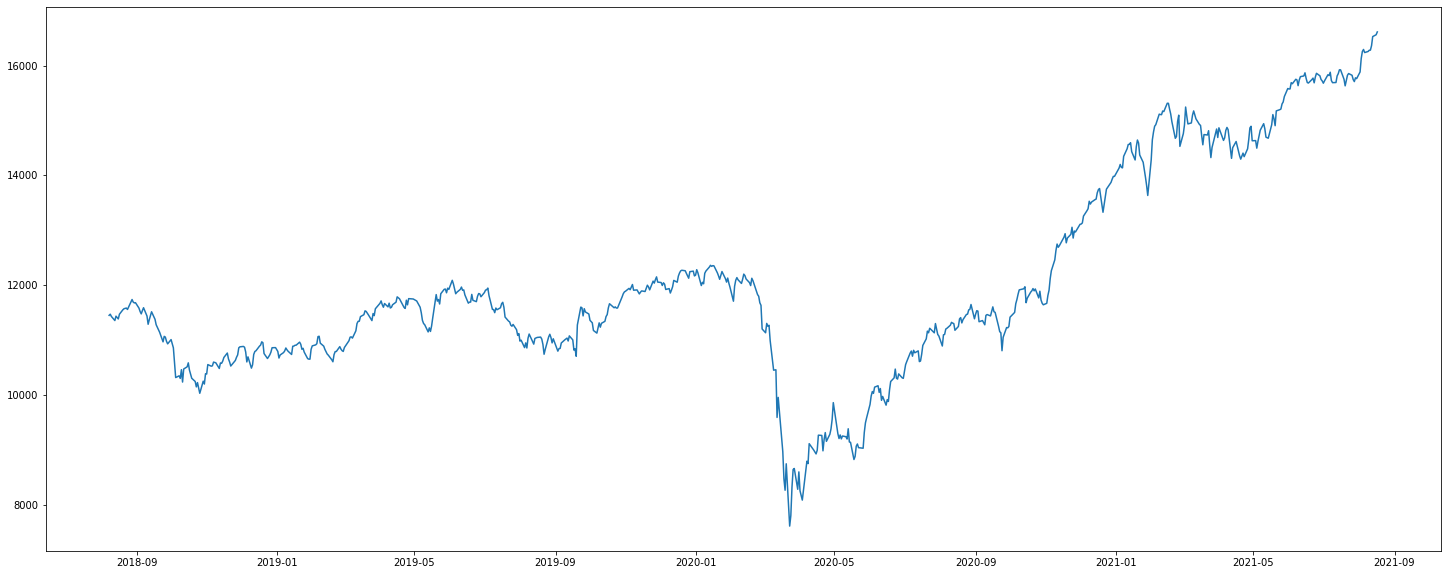

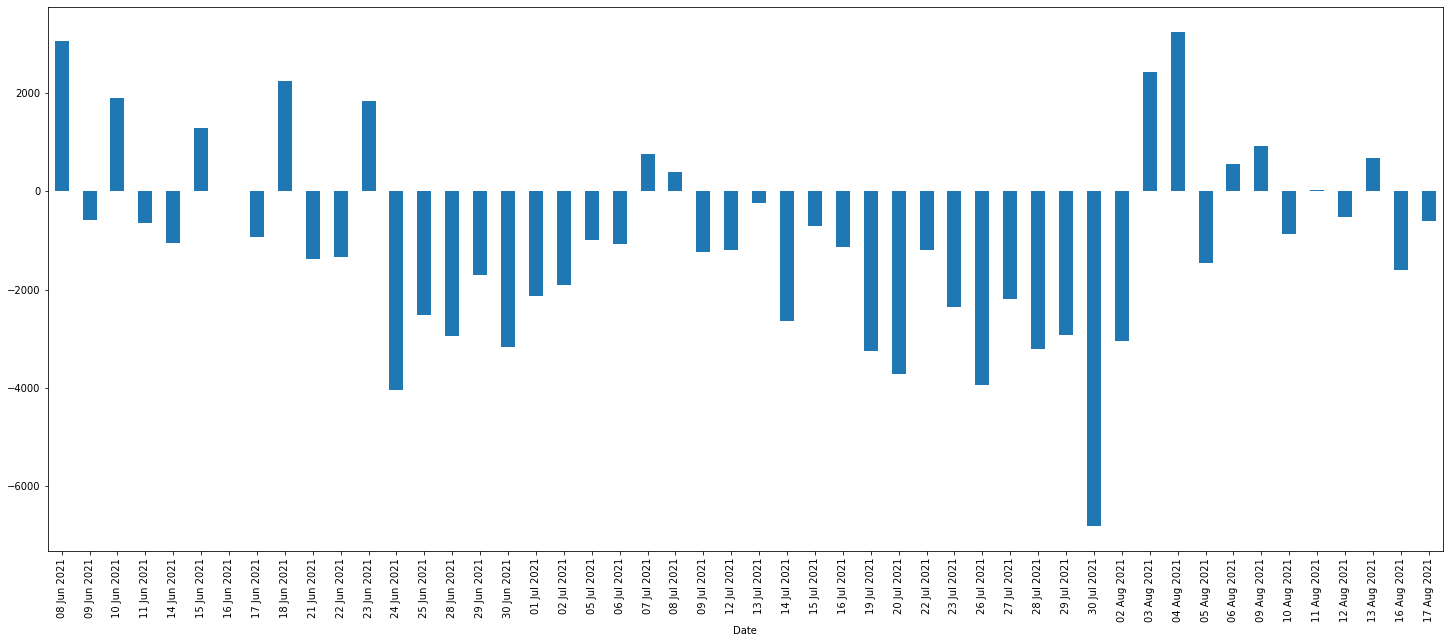

In [31]:
fig,ax=plt.subplots(3,1,figsize=(25,10),sharex=True)
ax[0].plot(fii_fig['macd'], label='Domestic')
ax[0].plot(fii_fig['signal'],color='g')
ax[0].plot(fii_fig['signal10'],color='r')
ax[2].plot(fii_fig['macdy'],label='Difference')
ax[2].plot(fii_fig['signaly'],color='g')
ax[2].plot(fii_fig['signal10y'],color='r')
#plt.plot(fii_fig.loc[:, :].index)
ax[1].plot(fii_fig['macdx'],label='FII')
ax[1].plot(fii_fig['signalx'],color='g')
ax[1].plot(fii_fig['signal10x'],color='r')

#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('Domestic Cash/FII in Market')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')
plt.show()
plt.figure(figsize=(25,10))
plt.plot(nifty.Close)
plt.show()
plt.figure(figsize=(25,10))
fii_fig['Cash'][-50:].plot.bar()
plt.show()

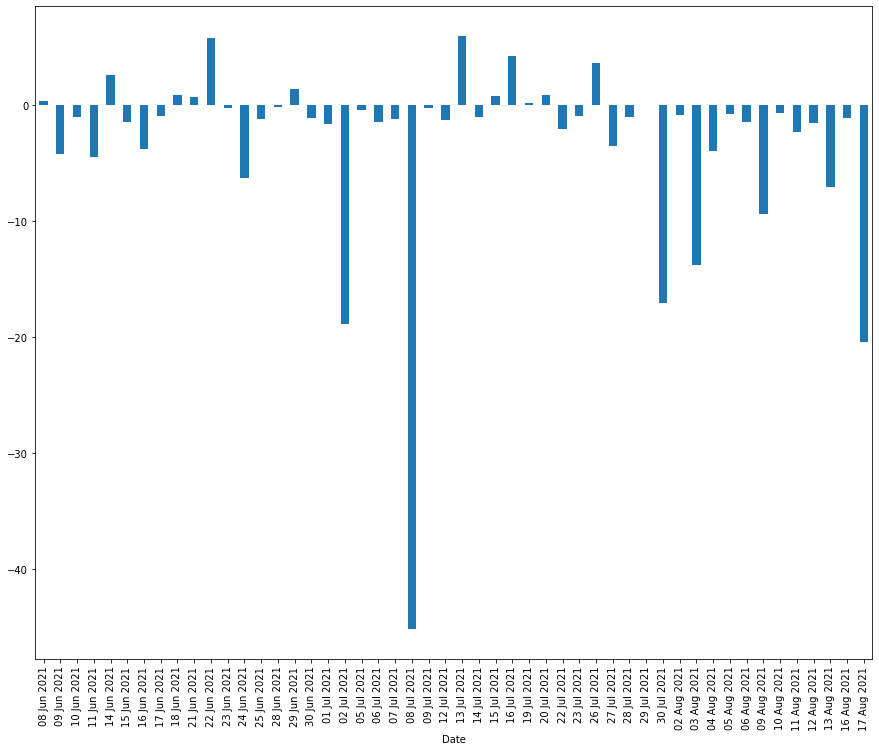

In [32]:
(fii_fig['FIIput'].pct_change()[-50:]).plot(kind='bar',figsize=(15,12))

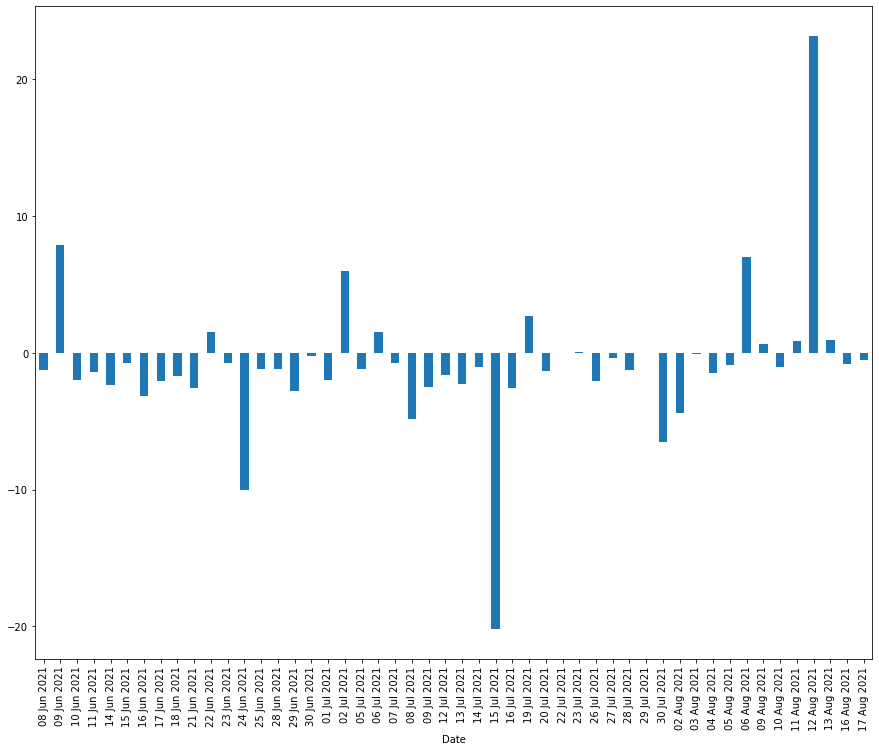

In [33]:
(fii_fig['FIIcall'].pct_change()[-50:]).plot(kind='bar',figsize=(15,12))

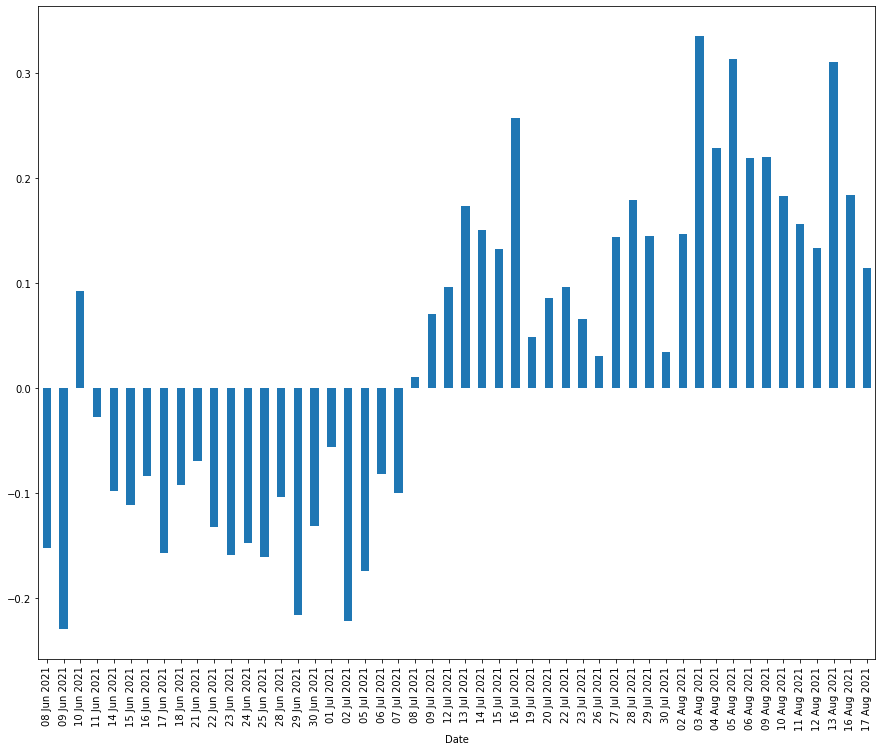

In [34]:
(fii_fig['FIIFutOI'].pct_change(10)[-50:]).plot(kind='bar',figsize=(15,12))


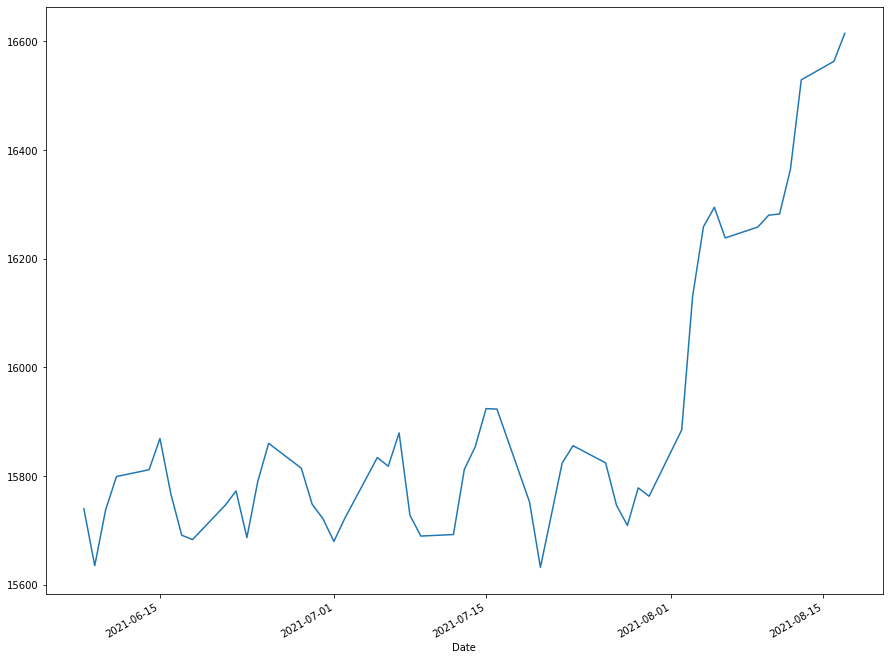

In [35]:
nifty['Close'][-50:].plot(figsize=(15,12))

In [36]:
fii_fig['MA200']=fii_fig.FIICash.rolling(window=200).mean()
fii_fig['MA50']=fii_fig.FIICash.rolling(window=50).mean()

In [37]:
fii_fig['macd']=fii_fig['FIICash'].ewm(span=50, adjust=False).mean()-fii_fig['FIICash'].ewm(span=200, adjust=False).mean()
fii_fig['signal']=fii_fig['macd'].ewm(span=35,adjust=False).mean()
fii_fig['signal10']=fii_fig['macd'].ewm(span=10,adjust=False).mean()
fii_fig['hist']=fii_fig['macd']-fii_fig['signal'] 


In [38]:
fii_fig['macd_dom']=fii_fig['DIIcash'].ewm(span=100, adjust=False).mean()-fii_fig['DIIcash'].ewm(span=200, adjust=False).mean()
fii_fig['signal_dom']=fii_fig['DIIcash'].ewm(span=50,adjust=False).mean()
fii_fig['hist_dom']=fii_fig['macd_dom']-fii_fig['signal_dom']

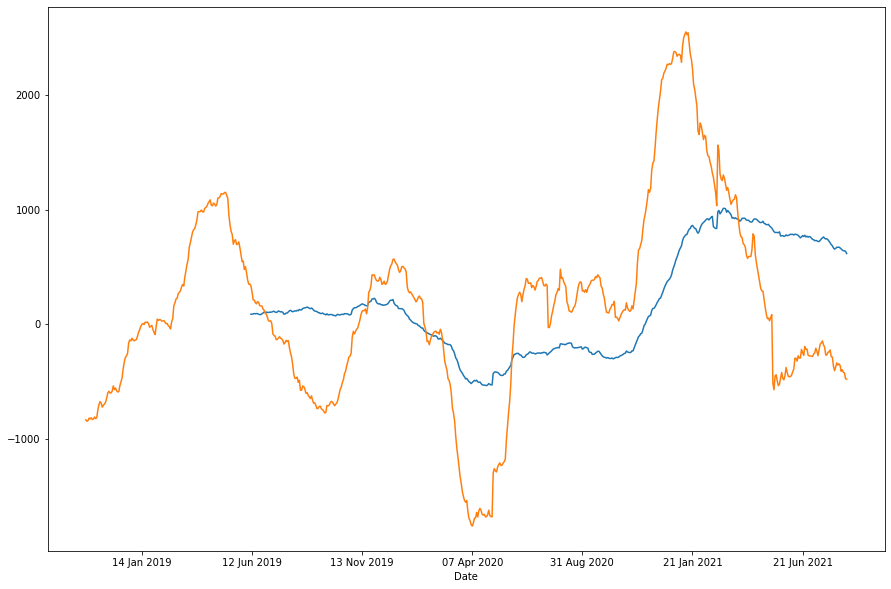

In [39]:
fii_fig.MA200.plot(figsize=(15,10))
fii_fig.MA50.plot()


# sample dataset from plotly express
df = fii_fig
# Filter and pivot dataset for each country,
# and add lines for each country
fig = go.Figure()
for c in ['MA200','MA50']:
    fig.add_traces(go.Scatter(x=df.index, y=df[c], mode='lines', name = c))

fig.show()

In [40]:


# sample dataset from plotly express
df = fii_fig
# Filter and pivot dataset for each country,
# and add lines for each country
fig = go.Figure()
for c in ['macd','signal']:
    fig.add_traces(go.Scatter(x=df.index, y=df[c], mode='lines', name = c))

fig.show()

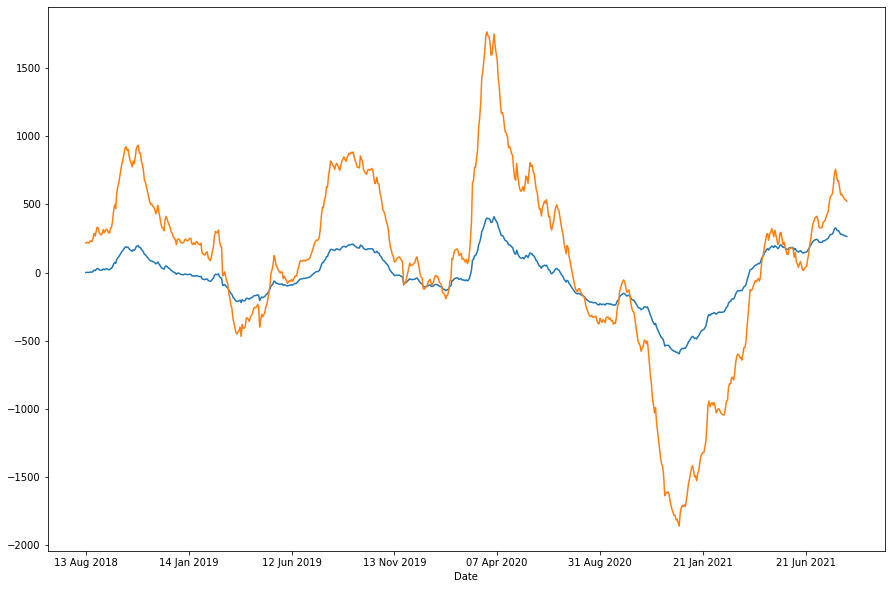

In [41]:
# sample dataset from plotly express
df = fii_fig
# Filter and pivot dataset for each country,
# and add lines for each country
fig1 = go.Figure()
for c in ['macd_dom','signal_dom']:
    fig1.add_traces(go.Scatter(x=df.index, y=df[c], mode='lines', name = c))

fig1.show()

fii_fig.macd_dom.plot(figsize=(15,10),xlabel='macd')
fii_fig.signal_dom.plot()
plt.show()


# Plot Smart Money (FII)

In [42]:
from plotly.subplots import make_subplots
df=fii_fig.reset_index()
fig = make_subplots(
    rows=2, cols=1,shared_xaxes=True,vertical_spacing=0.02,
    subplot_titles=("Smart Money","Nifty"))

fig.add_trace(go.Scatter(x=df.Date, y=df['macd'], mode='lines', name = 'macd'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df['signal'], mode='lines', name = 'signal'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['signal10'], mode='lines', name = 'signal10'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=nif.Date, y=nif['Close'], mode='lines', name = 'Close'),
              row=2, col=1)

fig.update_layout(height=500, width=900,
                  title_text="Smart Money And Nifty")

fig.show()

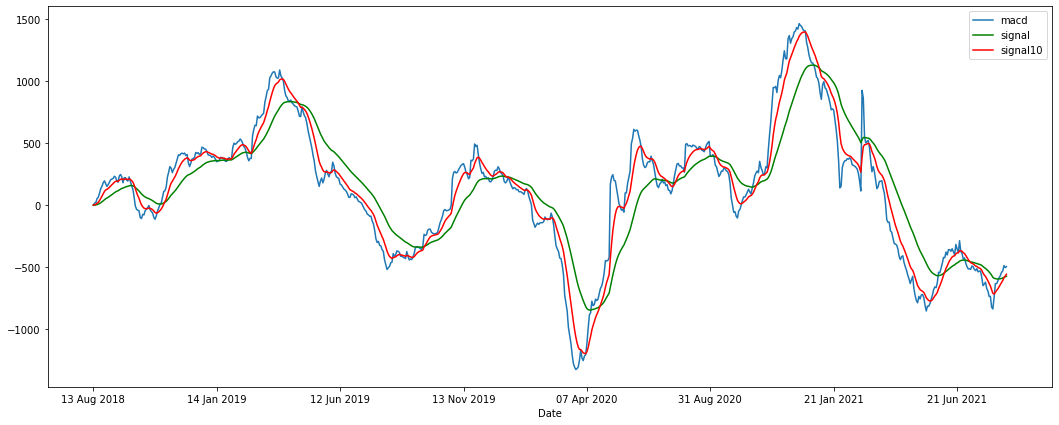

In [43]:
fii_fig['macd'].plot(figsize=(18,7))
fii_fig['signal'].plot(color='g')
fii_fig['signal10'].plot(color='r')
#plt.plot(fii_fig.loc[:, :].index)
plt.legend()
plt.show()


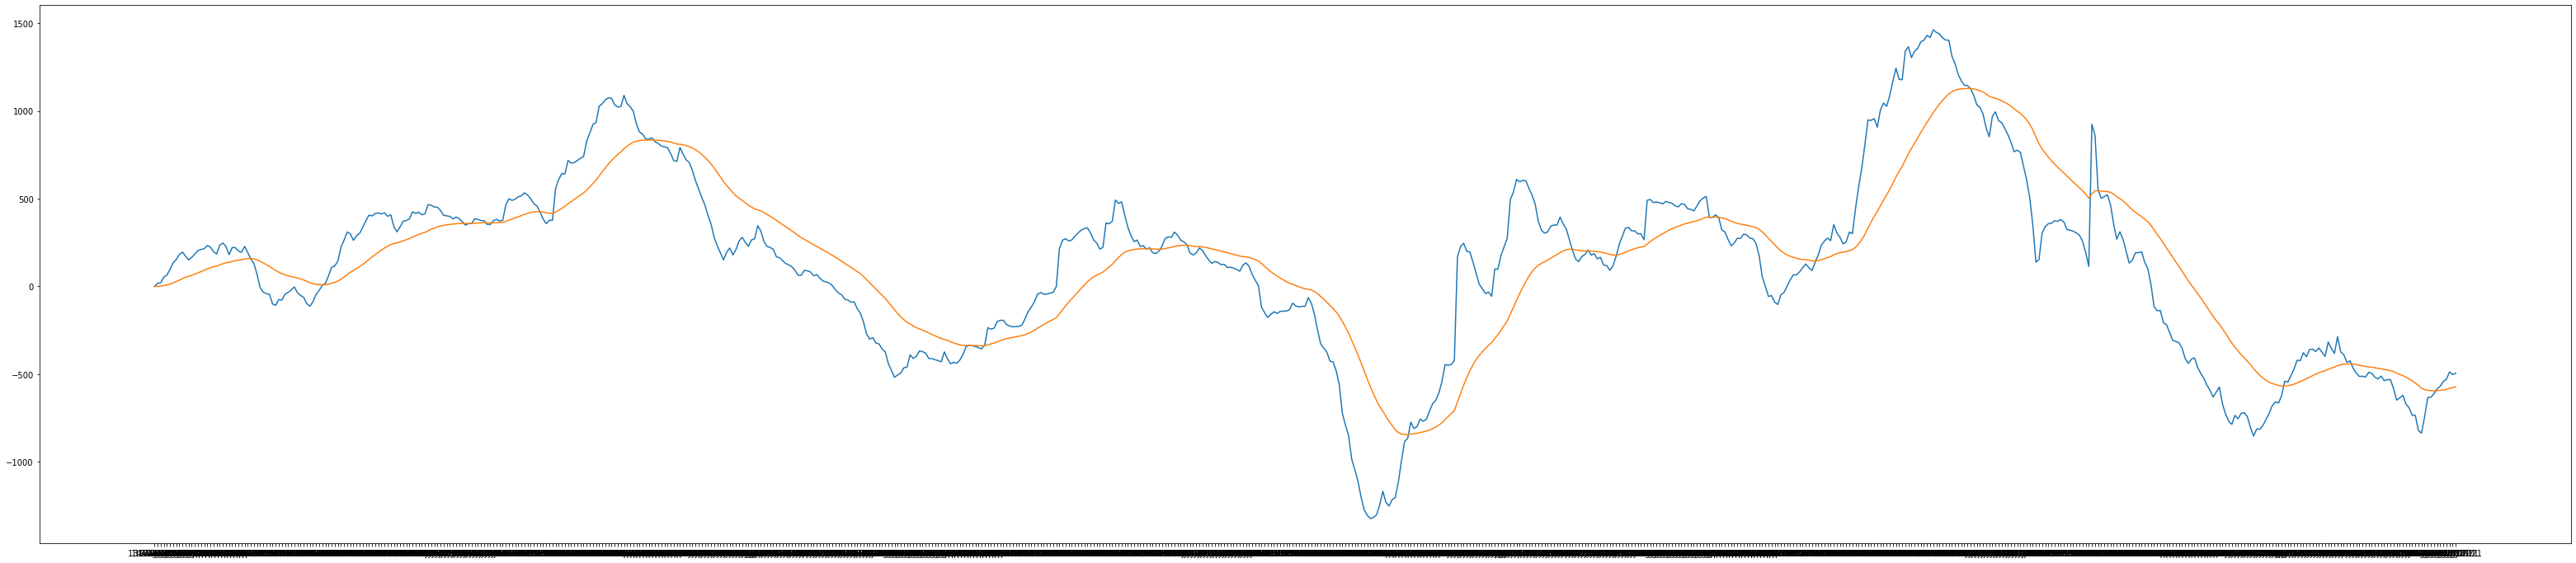

In [44]:
plt.figure(figsize=(55,12))
plt.plot(fii_fig.loc[:, :].index,fii_fig['macd'],label='MACD')
plt.plot(fii_fig.loc[:, :].index,fii_fig['signal'],label='Signal')
#plt.plot(fii_fig.loc[:, :].index)
plt.show()

In [45]:
nifty=nifty.reset_index()

In [46]:
nif.shape,df.macd.shape

((740, 7), (741,))

In [47]:
sample= pd.concat([nif['Close'] ,df['signal']][-len(nif):],axis=1)
sample=sample.replace(0,0.1)

In [48]:
sample['pct_chg']=sample['Close'].pct_change()
sample['macd_chg']=sample['signal'].pct_change()


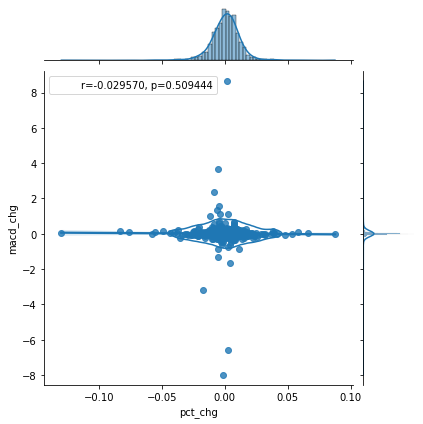

In [49]:
import seaborn as sns
from scipy.stats import pearsonr
g=sns.jointplot(x='pct_chg',y='macd_chg',data=sample,kind='reg').plot_joint(sns.kdeplot,n_levels=6)
r, p = pearsonr(sample['pct_chg'][-500:], sample['macd_chg'][-500:])
phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
g.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
plt.show()

In [50]:
df=fii_fig.reset_index()
f=px.line(df,x='Date',y=df['signal_dom'].rolling(window=5).mean())
f.add_scatter(x=df['Date'],y=df['signal_dom'].rolling(window=100).mean(), mode='lines')
f.show()
fi=px.line(nif,x='Date',y='Close')
fi.show()

In [51]:
fii_fig.tail(5)

,FIIcall,FIIput,FIIFuture,FIIFutOI,FIICash,DIIcash,Cash,macdfut,signalfut,signal10fut,histfut,macdy,signaly,signal10y,histy,macd,signal,signal10,hist,macdx,signalx,signal10x,histx,MA200,MA50,macd_dom,signal_dom,hist_dom
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11 Aug 2021,1.3,11.6,-905,14977,238,206,32,-14.303067,-0.568379,-8.203179,-13.734688,-1030.661194,-1094.173580,-1167.971986,63.512386,-542.047636,-589.975055,-623.660203,47.927418,-542.047636,-589.975055,-623.660203,47.927418,647.585,-397.60,277.026125,560.876747,-283.850622
12 Aug 2021,31.4,-6.2,889,14678,-212,308,-520,-7.797160,-0.718979,-8.164511,-7.078181,-1005.830713,-1089.265643,-1138.491755,83.434930,-529.479530,-586.614192,-606.536444,57.134662,-529.479530,-586.614192,-606.536444,57.134662,640.935,-420.26,273.862875,550.960012,-277.097137
13 Aug 2021,60.0,37.2,631,15936,820,150,670,-3.122327,-0.769048,-7.684303,-2.353278,-946.993005,-1081.361607,-1103.673800,134.368603,-487.115905,-581.086509,-584.823619,93.970604,-487.115905,-581.086509,-584.823619,93.970604,640.500,-425.44,269.182581,535.236090,-266.053509
16 Aug 2021,11.7,-2.6,-332,16115,-1088,506,-1594,-4.896083,-0.855028,-7.418758,-4.041055,-956.912577,-1074.447772,-1076.989942,117.535195,-502.466976,-576.718758,-569.849684,74.251782,-502.466976,-576.718758,-569.849684,74.251782,635.655,-477.18,268.094792,534.089576,-265.994784
17 Aug 2021,5.5,50.5,-459,15932,-344,266,-610,-7.472551,-0.992893,-7.423881,-6.479658,-937.177732,-1066.821659,-1051.569540,129.643927,-495.099736,-572.184368,-556.258784,77.084631,-495.099736,-572.184368,-556.258784,77.084631,616.360,-480.34,264.621914,523.576260,-258.954345


# Call n Put Purchase/Sale

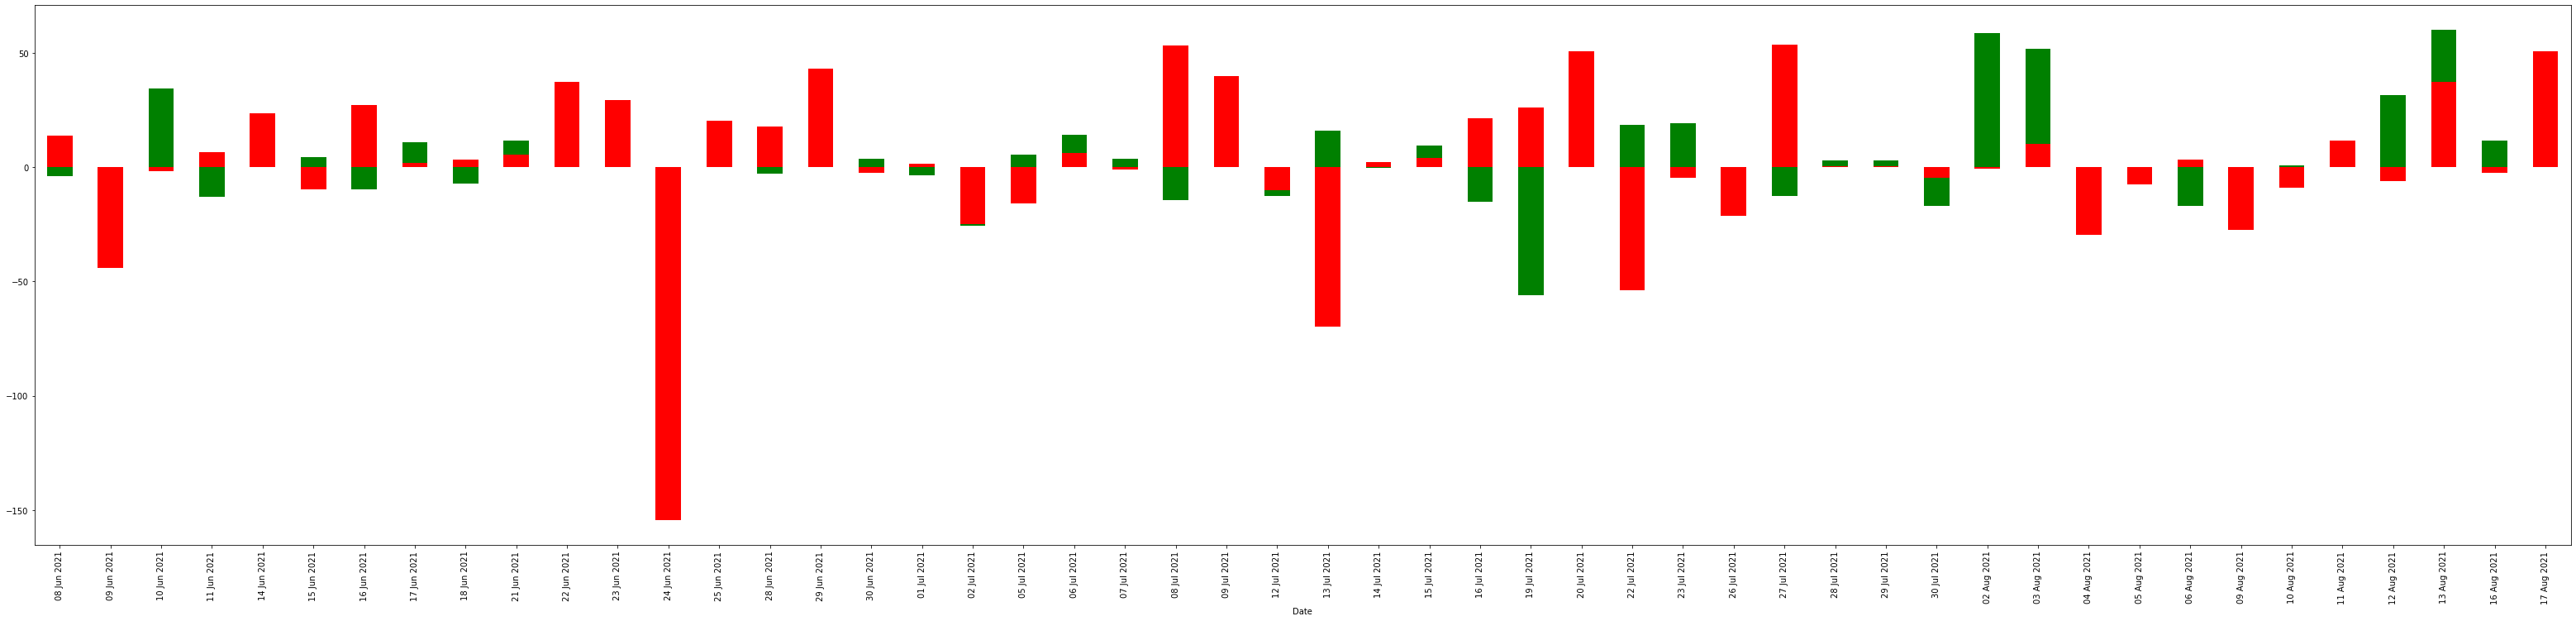

In [52]:
#fii_fig['FIIcall'][-200:].plot(kind='line',figsize=(55,12))
fii_fig['FIIcall'][-50:].plot(color='g',kind='bar',figsize=(55,12),label='Call')

fii_fig['FIIput'][-50:].plot(color='r',kind='bar',figsize=(55,12))

plt.show()


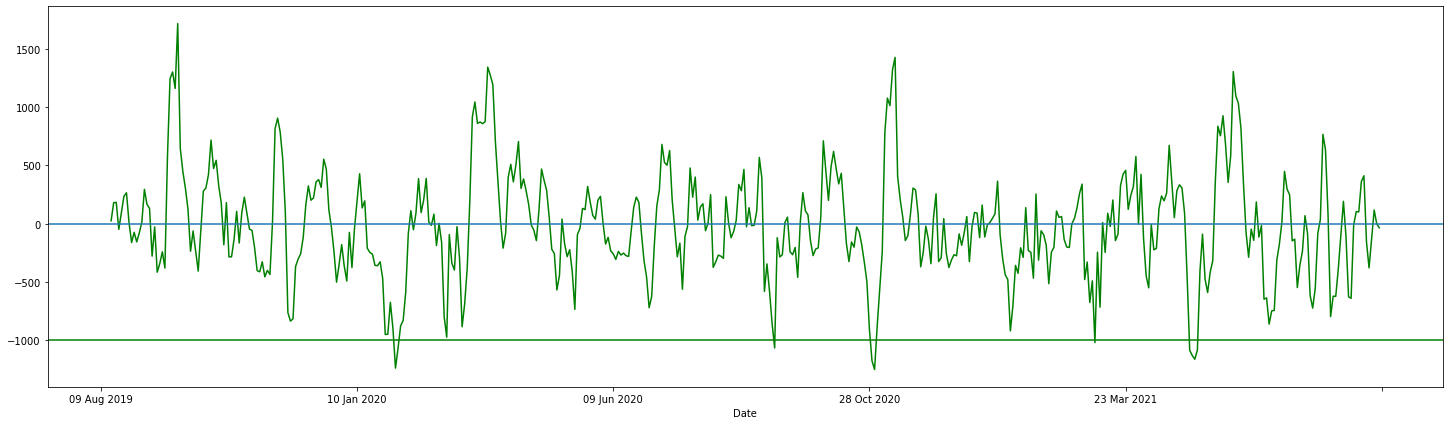

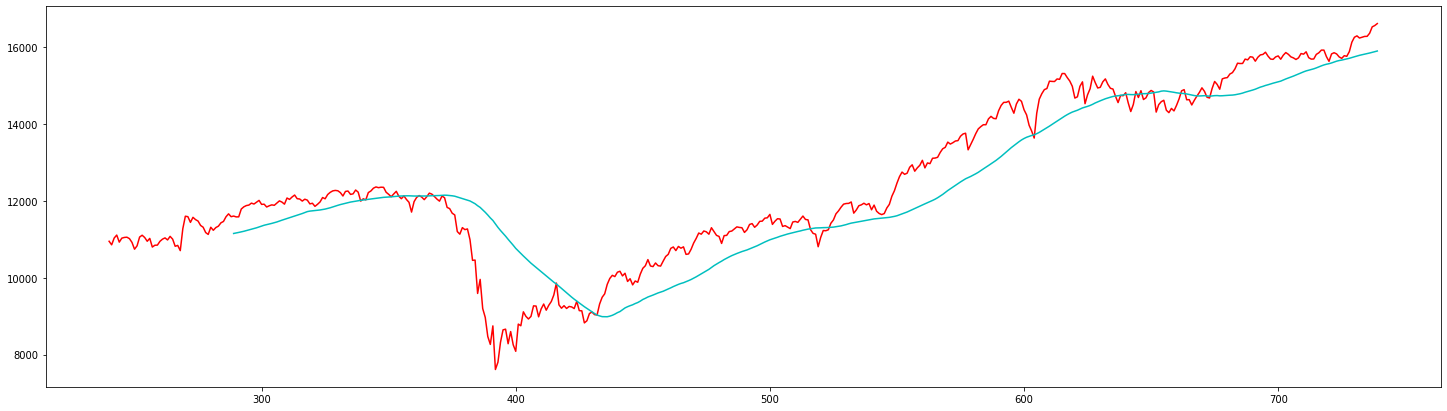

In [53]:
#fii_fig['FIIFuture'][-100:].plot(color='g',kind='line',figsize=(55,12))
fii_fig['FIIFuture'][-500:].rolling(window=5).mean().plot(color='g',kind='line',figsize=(25,7))
plt.axhline(y=0)
plt.axhline(y=-1000, color='g')
plt.show()
nifty['Close'][-500:].plot(color='r',kind='line',figsize=(25,7))
nifty['Close'][-500:].rolling(window=50).mean().plot(color='c',kind='line',figsize=(25,7))
plt.show()

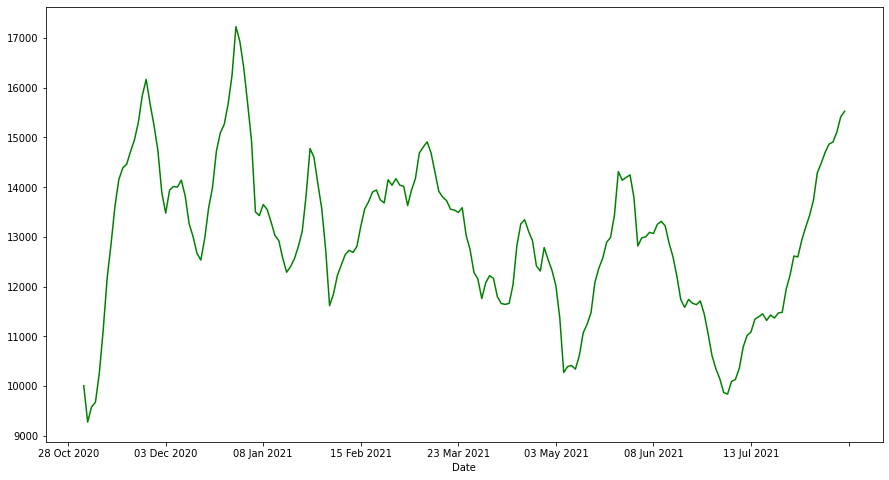

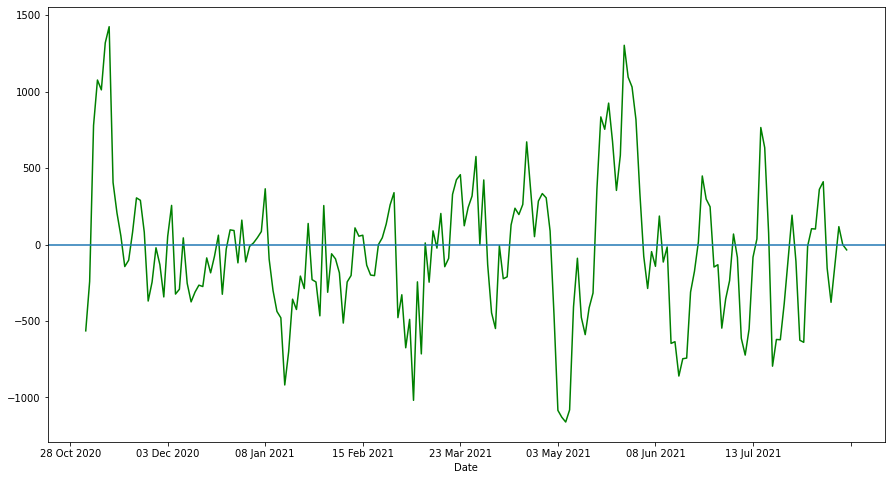

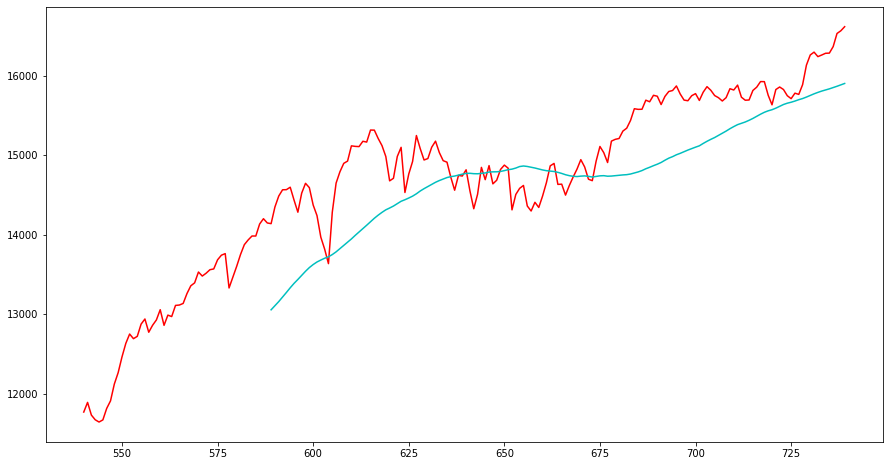

In [54]:
#fii_fig['FIIFuture'][-100:].plot(color='g',kind='line',figsize=(55,12))
fii_fig['FIIFutOI'][-200:].rolling(window=5).mean().plot(color='g',kind='line',figsize=(15,8))
plt.show()
fii_fig['FIIFuture'][-200:].rolling(window=5).mean().plot(color='g',kind='line',figsize=(15,8))
plt.axhline(y=0)
plt.show()
nifty['Close'][-200:].plot(color='r',kind='line',figsize=(15,8))
nifty['Close'][-200:].rolling(window=50).mean().plot(color='c',kind='line',figsize=(15,8))
plt.show()